## Herbarium 2022 
A herbarium is a collection of preserved plant specimens that are typically organized, labeled, and stored for the purpose of scientific study and reference. The New York Botanical Garden (NYBG) is a botanical garden located in New York City and is one of the largest in the United States.

The herbarium specimens provided by the NYBG likely represent a significant portion of the plants found in the northeastern United States, including New York City and surrounding areas. These specimens can be used to study the taxonomy, distribution, and evolution of plants in this region, as well as their relationship to plants found in other parts of the world. Additionally, herbarium specimens can provide important information on plant diversity and conservation efforts, and can serve as a reference for plant identification.

The background information on the herbarium specimens provided by the NYBG would likely include details on the collection and preservation methods used, the geographic and ecological regions represented in the collection, and the taxonomic classification of the specimens. Additionally, the data may include information on the history of the NYBG's herbarium, including any significant events or changes to the collection over time.

# Import libraries:

In [1]:
import pandas as pd
import numpy as np
import json

import logging as log
import os
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import ticker
#I commented this:
#from models import alexnet, mycnn, mycnn2, resnet
from torch.utils.tensorboard import SummaryWriter

from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from PIL import Image
import sys
import os
import glob

import gc
import cv2 as cv
import seaborn as sns


import pickle
from tqdm import tqdm
from torch import optim
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score
from tensorboardX import SummaryWriter
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR,ReduceLROnPlateau
from torch.utils import data

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader


# Some configurations:

In [2]:
# Define relevant variables for the ML task
num_classes = 15501
learning_rate = 0.001
num_epochs = 5  # actual 20 epochs
workers = 0
pin_memory = False
batch_size = 64

In [3]:

# Device will determine whether to run the training on GPU or CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    deviceid = torch.cuda.current_device()
    log.info(f"Gpu device {torch.cuda.get_device_name(deviceid)}")


## Custom dataset classes:
The herbarium dataset consists of images of specimens from 15,501 species of vascular plants, with each image displaying a single specimen. 

The data has been divided into two sets: a training set, which makes up 80% of the total data, and a test set, which makes up the remaining 20%. To ensure a balanced representation of the species, each category has at least one specimen in both the training and test datasets. It's worth noting that the distribution of species in the test set may not be exactly the same as in the training set, and the number of examples for each species in the training set is capped at a maximum of 80.

The "hierarchical structure of classes" refers to the organization of the classes or categories in a tree-like structure, where some categories are grouped under larger, more general categories. In the case of the herbarium dataset, it could refer to the taxonomic classification of the plant specimens, where each specimen belongs to a species, genus, family, order, and so on, forming a hierarchical structure of taxonomic categories. This hierarchical structure provides a way to organize and group related specimens, making it easier to understand the relationships between different species and to study the evolution and diversity of plants.

The labeling of the herbarium dataset may be a challenge due to its format. The data is divided into two parts: a training dataset and a testing dataset, as well as a JSON file. The way the data is organized and labeled can impact the accuracy and effectiveness of machine learning models that are trained on this data. Ensuring that the labeling is consistent and accurately reflects the relationships between different specimens is critical to achieving accurate results. Any inconsistencies or errors in labeling can lead to misleading or incorrect conclusions about the data. Thus, the labeling of the data may be one of the issues that needs to be addressed in order to effectively use this dataset for machine learning.

There is a field in JSON files that its name is "***Category_ID***". It can be considered a suitable criterion for labeling the data because it is a unique identifier that is derived from the combination of the Species and Genus information. This six-digit identifier is placed on the left side of each photo and ensures that each specimen has a unique identifier, making it an effective way to label and categorize the data. By linking the Category ID with the Species and Genus information, the herbarium dataset can be organized and labeled in a way that accurately reflects the taxonomic relationships between different specimens. This information can then be used to train machine learning models and to make meaningful observations about the data. The use of the Category ID as a criterion for labeling the herbarium dataset can therefore play a critical role in ensuring the accuracy and reliability of the data.

In [4]:
train_dir = '/kaggle/input/herbarium-2022-fgvc9/train_images/'
test_dir = '/kaggle/input/herbarium-2022-fgvc9/test_images/'

with open("/kaggle/input/herbarium-2022-fgvc9/train_metadata.json") as json_file:
    train_meta = json.load(json_file)
with open("/kaggle/input/herbarium-2022-fgvc9/test_metadata.json") as json_file:
    test_meta = json.load(json_file)

## convert JSON to Data frame:
In order to effectively use the information in the JSON file of the herbarium dataset, it is necessary to convert it into a dataframe. This dataframe will allow you to easily access and manipulate the information in the file, including the Category ID and location address of each image. However, simply creating the dataframe is not sufficient to use the data in a machine learning model. In order to properly load and process the data, you will need to write a custom data loader. This data loader will need to handle the unique format of the herbarium dataset, and may not be able to use the existing data loaders from PyTorch or other Python libraries. Writing a custom data loader can be a complex task, but it is necessary in order to ensure that the herbarium dataset is loaded and processed correctly, and that the information from the JSON file is accurately used to train your machine learning models.

In [5]:
image_ids = [image["image_id"] for image in train_meta["images"]]
image_dirs = [train_dir + image['file_name'] for image in train_meta["images"]]
category_ids = [annotation['category_id'] for annotation in train_meta['annotations']]
genus_ids = [annotation['genus_id'] for annotation in train_meta['annotations']]

test_ids = [image['image_id'] for image in test_meta]
test_dirs = [test_dir + image['file_name'] for image in test_meta]

train_df = pd.DataFrame({
    "image_id" : image_ids,
    "image_dir" : image_dirs,
    "category" : category_ids,
    "genus" : genus_ids})

test_df = pd.DataFrame({
    "test_id" : test_ids,
    "test_dir" : test_dirs
})


train_df.head()

image_id                                          image_dir  category  \
0  00000__001  /kaggle/input/herbarium-2022-fgvc9/train_image...         0   
1  00000__002  /kaggle/input/herbarium-2022-fgvc9/train_image...         0   
2  00000__003  /kaggle/input/herbarium-2022-fgvc9/train_image...         0   
3  00000__004  /kaggle/input/herbarium-2022-fgvc9/train_image...         0   
4  00000__005  /kaggle/input/herbarium-2022-fgvc9/train_image...         0   

   genus  
0      1  
1      1  
2      1  
3      1  
4      1

## Mapping Genus:

In [6]:
genus_map = {genus['genus_id'] : genus['genus'] for genus in train_meta['genera']}
train_df['genus'] = train_df['genus'].map(genus_map)
train_df

image_id                                          image_dir  \
0       00000__001  /kaggle/input/herbarium-2022-fgvc9/train_image...   
1       00000__002  /kaggle/input/herbarium-2022-fgvc9/train_image...   
2       00000__003  /kaggle/input/herbarium-2022-fgvc9/train_image...   
3       00000__004  /kaggle/input/herbarium-2022-fgvc9/train_image...   
4       00000__005  /kaggle/input/herbarium-2022-fgvc9/train_image...   
...            ...                                                ...   
839767  15504__032  /kaggle/input/herbarium-2022-fgvc9/train_image...   
839768  15504__033  /kaggle/input/herbarium-2022-fgvc9/train_image...   
839769  15504__035  /kaggle/input/herbarium-2022-fgvc9/train_image...   
839770  15504__036  /kaggle/input/herbarium-2022-fgvc9/train_image...   
839771  15504__037  /kaggle/input/herbarium-2022-fgvc9/train_image...   

        category        genus  
0              0        Abies  
1              0        Abies  
2              0        Abies  
3              0        Abies  
4              0        Abies  
...          ...          ...  
839767     15504  Zygophyllum  
839768     15504  Zygophyllum  
839769     15504  Zygophyllum  
839770     15504  Zygophyllum  
839771     15504  Zygophyllum  

[839772 rows x 4 columns]

In [7]:
print('Top 15 Genus ')
print(train_df['genus'].value_counts().head(15))
print()

Top 15 Genus 
Carex           24743
Astragalus      15192
Penstemon       12256
Eriogonum       10063
Erigeron         7135
Euphorbia        7070
Cyperus          6412
Phacelia         6165
Castilleja       5485
Juncus           5440
Quercus          5230
Salix            4946
Crataegus        4890
Rhynchospora     4635
Asclepias        4540
Name: genus, dtype: int64



## Data Visualization:

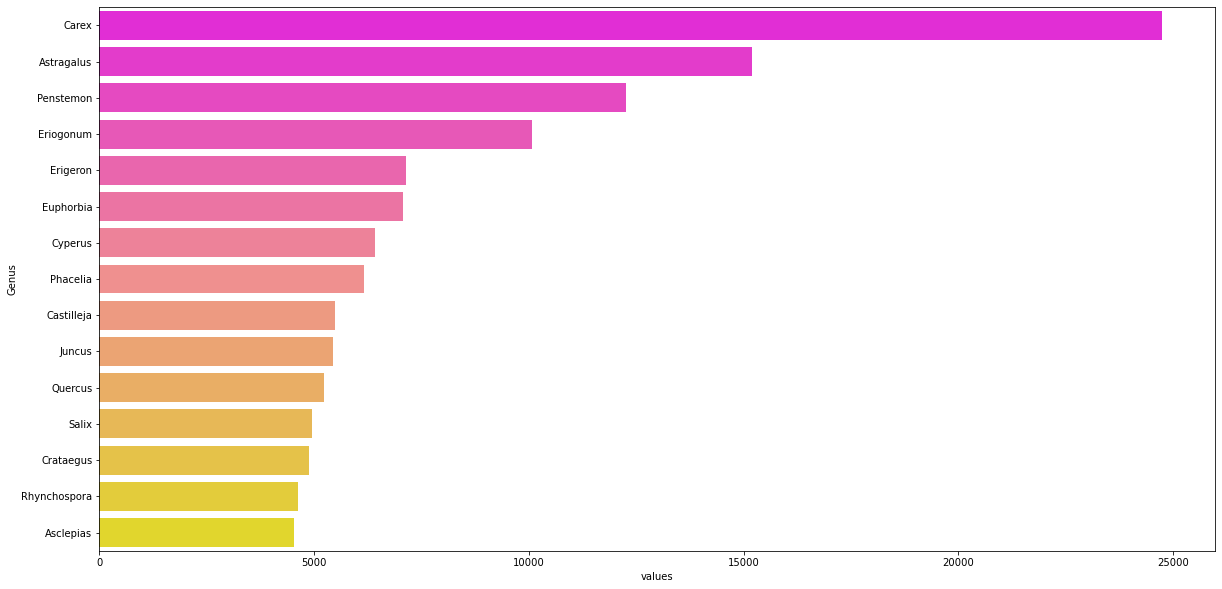

In [11]:
data = train_df['genus'].value_counts().head(15)
data = pd.DataFrame({'Genus' : data.index,
                     'values' : data.values})
plt.figure(figsize = (20, 10))
sns.barplot(x='values', y = 'Genus', data = data , palette='spring')
plt.show()

In [12]:
def show_images(speices):
    images = train_df.loc[train_df['genus'] == speices]['image_dir'][:6]
    i = 1
    fig = plt.figure(figsize = (18, 18))
    plt.suptitle(speices, fontsize = '30')
    for image in images:
        img = cv.imread(image)
        ax = fig.add_subplot(2, 3, i)
        ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        ax.set_axis_off()
        i += 1
    plt.show()

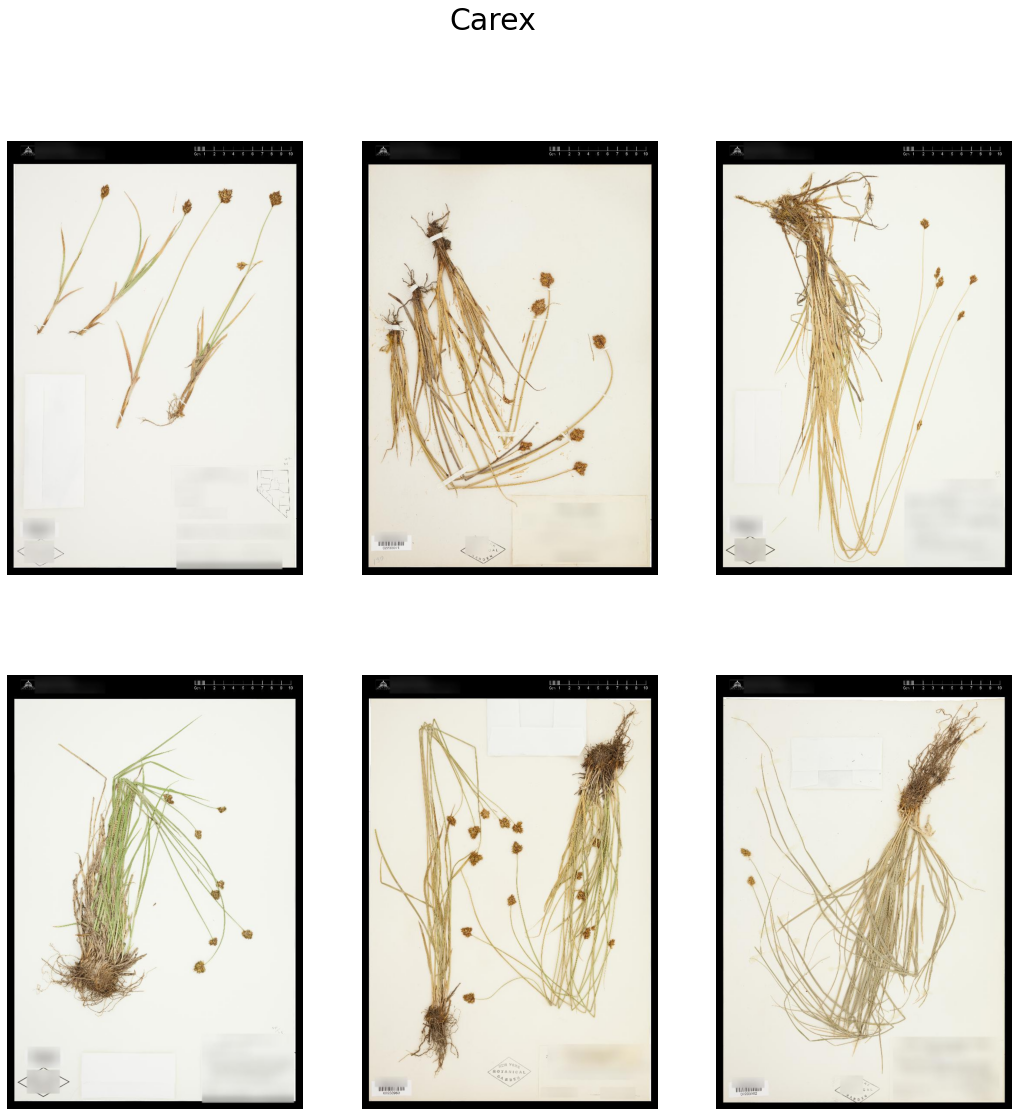

In [12]:
show_images('Carex')

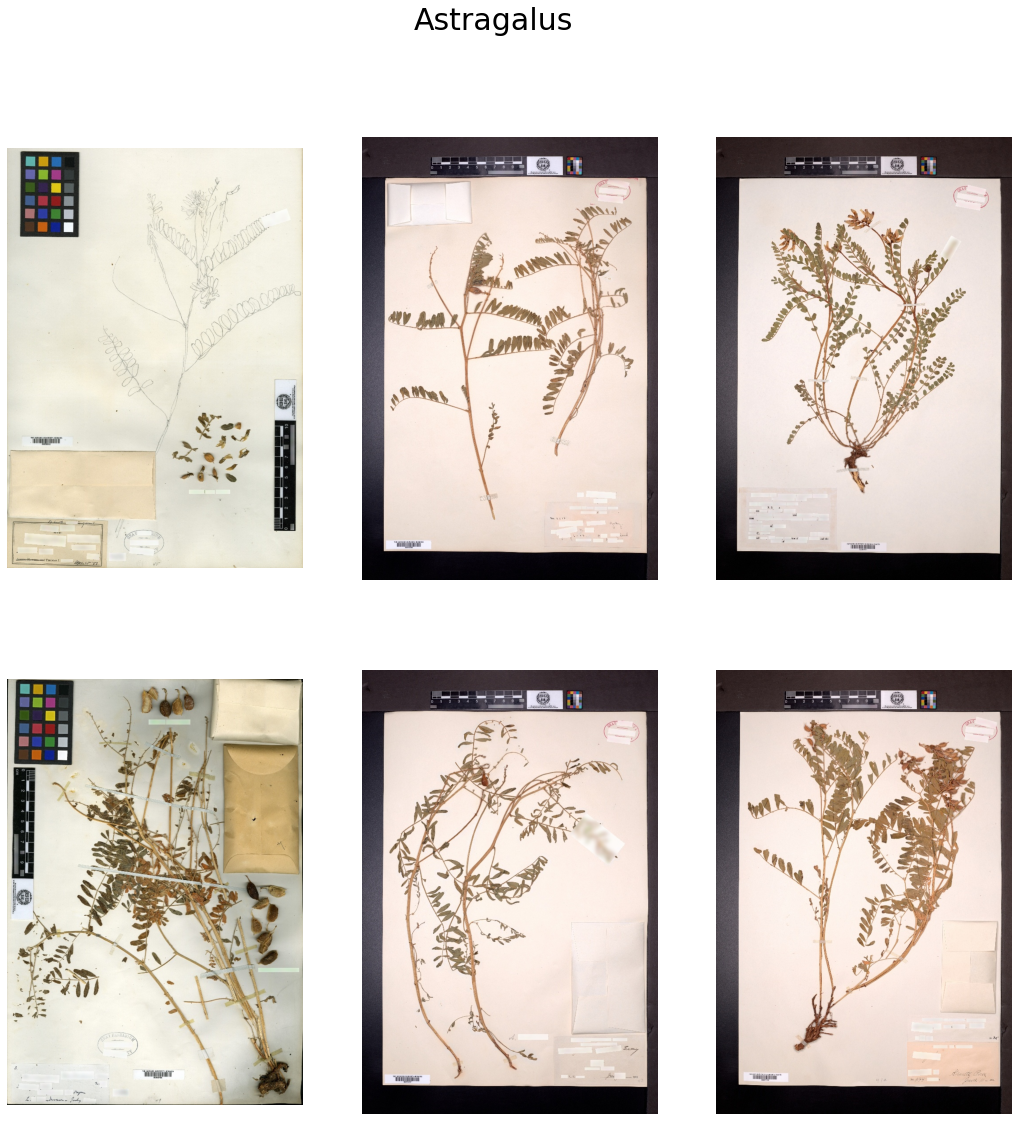

In [26]:
show_images('Astragalus')

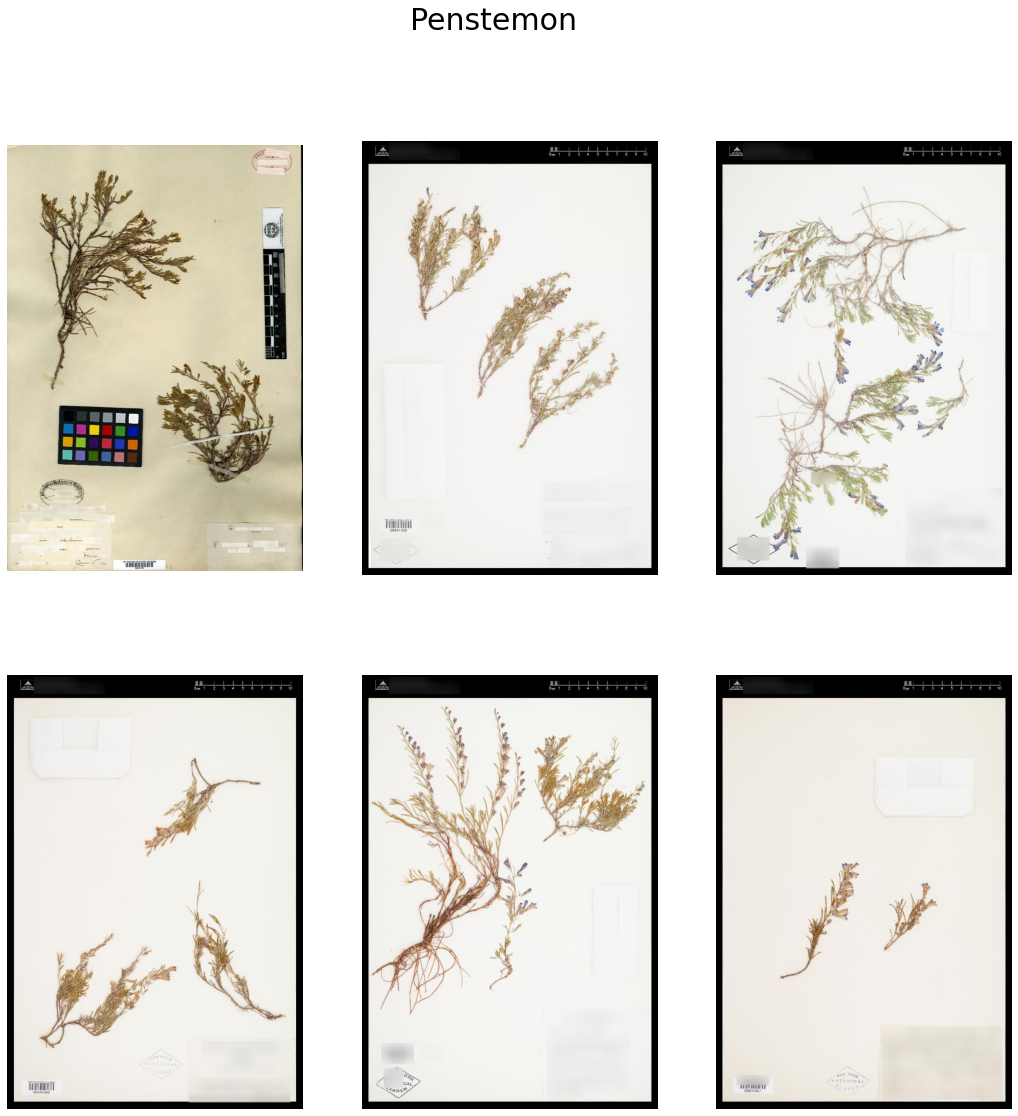

In [27]:
show_images('Penstemon')

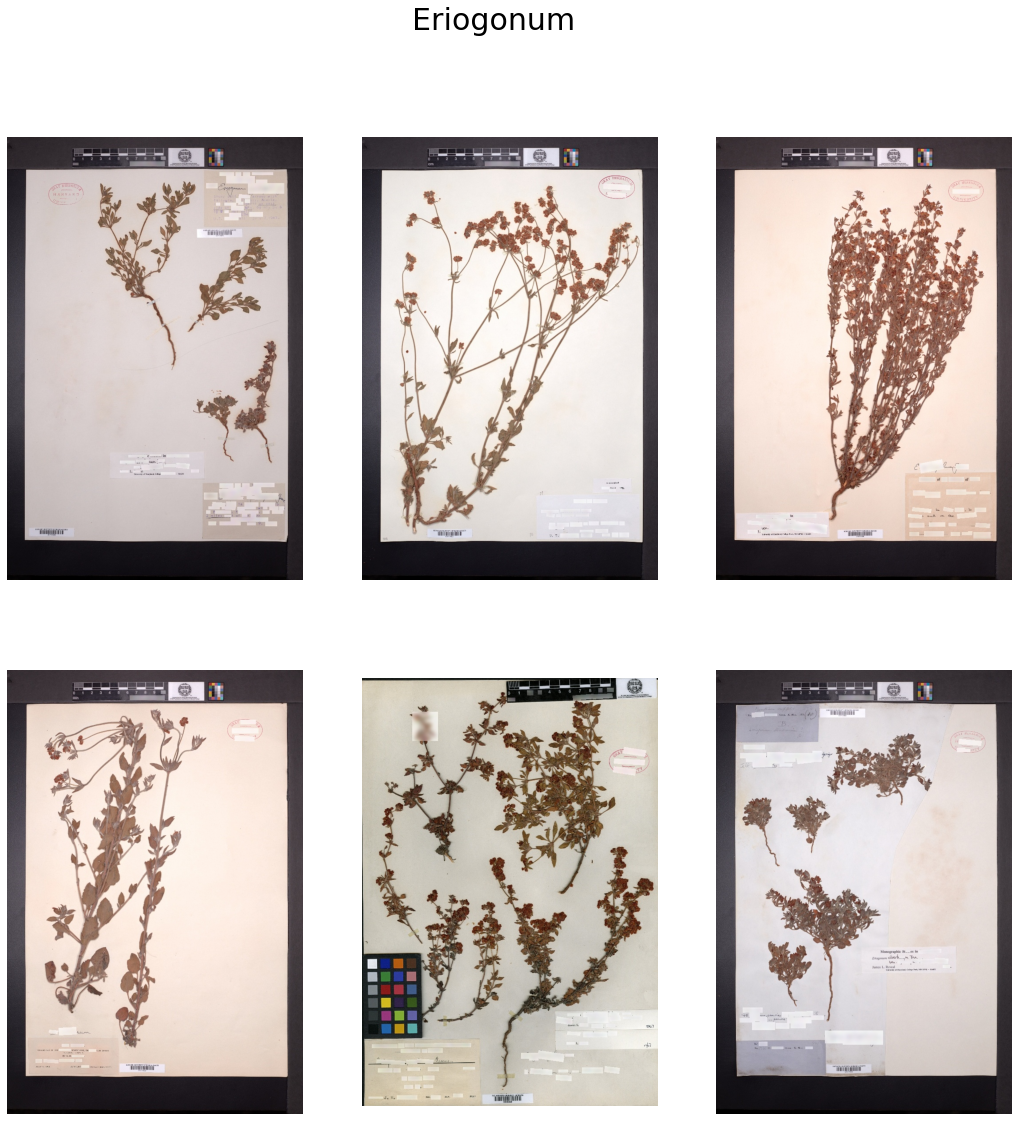

In [28]:
show_images('Eriogonum')

# Training:

In [14]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [15]:
BATCH = 128
EPOCHS = 5

LR = 0.01
IM_SIZE = 224 

X_Train, Y_Train = train_df['image_dir'].values, train_df['category'].values

Transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [11]:
len(train_df['category'])

839772

In [16]:
class GetData(Dataset):
    def __init__(self, FNames, Labels, Transform):
        self.fnames = FNames
        self.transform = Transform
        self.labels = Labels         
        
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):       
        x = Image.open(self.fnames[index])
    
        if "train" in self.fnames[index]:             
            return self.transform(x), self.labels[index]
        elif "test" in self.fnames[index]:            
            return self.transform(x), self.fnames[index]
                
trainset = GetData(X_Train, Y_Train, Transform)
trainloader = DataLoader(trainset, batch_size=BATCH, shuffle=True)

N_Classes = train_df['category'].nunique()
next(iter(trainloader))[0].shape

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


# Select the model you want to train
## ResNet50:

ResNet (Residual Network) is a type of deep neural network that was introduced in 2015 by researchers at Microsoft. The key innovation in ResNet is the use of residual connections, which allow the network to train deeper architectures without suffering from the vanishing gradient problem. Training a ResNet typically involves using stochastic gradient descent (SGD) with backpropagation to optimize the model's parameters with respect to a loss function, such as cross-entropy. This is done by iteratively updating the weights of the network in order to reduce the difference between the predicted output and the true output. Data augmentation techniques such as random cropping and flipping can be used to increase the diversity of the training set and improve the generalization of the model.

# Change the last layer of the Model:
The challenge of training the herbarium dataset with a standard model such as ResNet50 can be significant, given the large number of classes in the data. You encountered an error while training the model, which took some time to resolve. The error was caused by a mismatch between the number of classes in the data and the number of output nodes in the last layer of the ResNet structure. The standard ResNet50 model has an output layer with 1000 nodes, while the herbarium dataset has 15501 classes. To resolve this issue, you had to change the last layer of the ResNet structure to have an output of 15501 nodes, which corresponds to the number of classes in the data. This adjustment to the model architecture was necessary to ensure that the model was capable of accurately categorizing the herbarium specimens and to prevent errors during training. It should be mentioned that this really simple solution took more than two weeks time to find!

In [22]:
model = torchvision.models.resnet50()
model.fc = nn.Linear(2048, 15501)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
print(model.fc.out_features) 
print(train_df['category'].nunique())

15501
15501


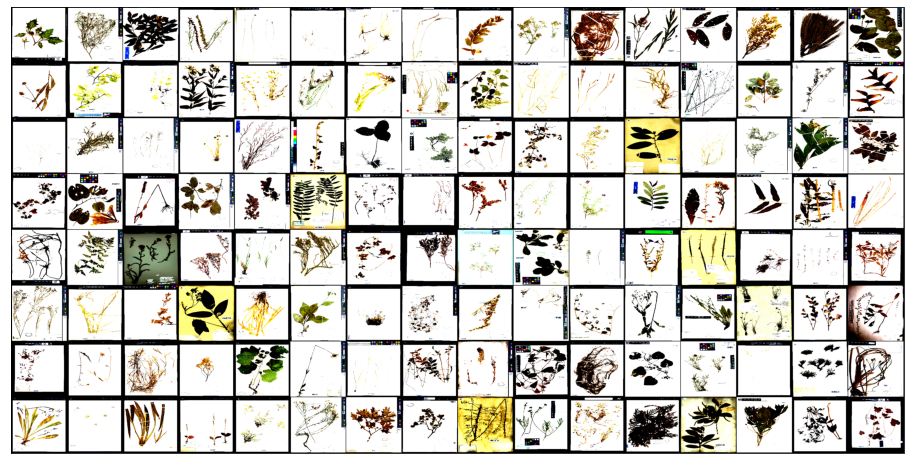

In [14]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,20))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(trainloader)

In [30]:
#(fc): Linear(in_features=2048, out_features=1000, bias=True)
for name, param in model.named_parameters():
    if 'fc' not in name:
        print(name, param.requires_grad)
        param.requires_grad=False

model.fc = nn.Linear(2048, 15501)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.0.conv3.weight False
layer1.0.bn3.weight False
layer1.0.bn3.bias False
layer1.0.downsample.0.weight False
layer1.0.downsample.1.weight False
layer1.0.downsample.1.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.1.conv3.weight False
layer1.1.bn3.weight False
layer1.1.bn3.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer1.2.conv3.weight False
layer1.2.bn3.weight False
layer1.2.bn3.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2

In [25]:
# initialize our optimizer and loss function
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
lossFn = nn.CrossEntropyLoss()


# Train Model:
## Training a CNN with ResNet involves several steps:

Prepare the dataset: This includes loading the images and labels, preprocessing the data (e.g. resizing, normalizing), and splitting the data into training and validation sets.

Load the ResNet model: This can be done using a library such as Keras or PyTorch, which provide pre-trained ResNet models that can be easily loaded and used for transfer learning.

Freeze the layers: Since ResNet is pre-trained on a large dataset, the initial layers of the model contain valuable features that can be used for the new task. So it's often a good idea to freeze the initial layers of the model and only train the last few layers, which are randomly initialized.

Compile the model: This step involves specifying the optimizer, loss function, and metrics that will be used to train the model.

Train the model: This involves passing the training data through the model, updating the model's parameters based on the loss function, and repeating this process for a number of epochs.

Validate the model: After training, the model is evaluated on a validation dataset to estimate its performance on unseen data.

Fine-tune the model: Based on the validation results, you can adjust the model's architecture, hyperparameters, or the data preprocessing steps to improve its performance.

Test the model: Finally, the model is evaluated on a test dataset to get a final estimate of its performance on unseen data.

It's important to note that training deep neural networks like ResNet can be computationally expensive and time-consuming. It's also important to have a good balance of dataset to avoid overfitting.



In [26]:

# -------------------------------------------------------------------------------------------------------
# Train the model
# -------------------------------------------------------------------------------------------------------

for images, labels in trainloader:
    log.info(f"Shape of X [N, C, H, W]: {images.shape}")
    log.info(f"Shape of y: {labels.shape} {labels.dtype}")
    # test one flow
    # pred = model(x)
    # loss = lossFn(pred, y)
    break
total_step = len(trainloader)
log.info(f"Total steps: {total_step}")

stepsize = total_step // 100
if stepsize < 10:
    stepsize = 10


In [ ]:
# loop over our epochs
for epoch in range(0, num_epochs):
    # set the model in training mode
    model.train()  # IMPORTANT otherwise the model is not in training mode
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainAccuracy = 0
    totalTrainAccuracy = 0
    valCorrect = 0

    # loop over the training set
    for i, (images, labels) in enumerate(trainloader):
        
        print (i)

        try:
            # Train in auto-mode with 16 bit mode
            # with torch.autocast(device_type='cuda', dtype=torch.float16):
            # Train in normal mode
            with torch.autocast(device_type="cuda", dtype=torch.float32):
                # send the input to the device
                (images, labels) = (images.to(device), labels.to(device))
                # perform a forward pass and calculate the training loss
                outputs = model(images)
               
                # output is float16 because linear layers autocast to float16.
                # assert outputs.dtype is torch.float16 or 64

                loss = lossFn(outputs, labels)
                print ("**")
                # zero out the gradients, perform the backpropagation step,
                # and update the weights
                #writer.add_scalar("Loss/train", loss,  (epoch * total_step)+(i+1))
                opt.zero_grad()  # IMPORTANT otherwise the gradients of previous batches are not zeroed out
        except Exception as e:
            log.error(f"Exception in data processing- skip and continue = {e}")
        loss.backward()
        totalTrainLoss += loss
        opt.step()
        # Get the predicted values
        _, predicted = torch.max(outputs.data, 1)
        trainAccuracy = (predicted == labels).float().sum().item()
        trainAccuracy = 100 * trainAccuracy / labels.size(0)
        #writer.add_scalar("Accuracy/train", trainAccuracy,(epoch * total_step)+(i+1))
        totalTrainAccuracy += trainAccuracy
        # if (i // stepsize) % 10 == 0:
        log.info(
            "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} Accuracy: {:.4f}".format(
                epoch + 1, num_epochs, i + 1, total_step, loss, trainAccuracy
            )
        )

    

    avgTrainLoss = totalTrainLoss / len(trainloader)
    avgAccuracy = totalTrainAccuracy / len(trainloader)
    log.info(
        "--->Epoch [{}/{}], Average Loss: {:.4f} Average Accuracy: {:.4f}".format(
            epoch + 1, num_epochs, avgTrainLoss, avgAccuracy
        )
    )

    print('Epoch [{}/{}], Loss: {:.4f}, TrainAccuracy: {:.4f}, averageloss: {:.4f}, averageacc: {:.4f} '.format(epoch+1, num_epochs, loss, trainAccuracy, avgTrainLoss, avgAccuracy))

    # End Epoch loop

0


/opt/conda/lib/python3.7/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


**
1
**
2
**
3
**
4
**
5
**
6
**
7
**
8
**
9
**
10
**
11
**
12
**
13
**
14
**
15
**
